In [16]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
from pathlib import Path
import time
import logging
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

In [28]:
# ---------- CONFIG ----------
BASE = Path(r"E:\MSc Big Data Analytics in Football\WSL project\Statsbombpy data")
RAW_FILE = BASE / "wsl_events_with_gamestate.csv"
OUTPUT_EVENTS = BASE / "wsl_events_with_gamestate_zones.csv"
OUTPUT_SHOT_PROBS = BASE / "shot_probabilities_per_zone.csv"
PITCH_W, PITCH_H = 120.0, 80.0
GRID_X, GRID_Y = 12, 8
CELL_X, CELL_Y = PITCH_W / GRID_X, PITCH_H / GRID_Y
NUM_ZONES = GRID_X * GRID_Y

HYPERPARAMS = {
    "gamma": 0.95,
    "tol": 1e-6,
    "max_iter": 500,
    "max_dist_threshold": 60.0  # Max plausible transition distance in meters
}

# Logging setup
LOG_FILE = BASE / "xt_model_construction.log"
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[logging.FileHandler(LOG_FILE, encoding='utf-8'), logging.StreamHandler()]
)
logger = logging.getLogger(__name__)

In [29]:
# ---------- STEP 1: Load raw events ----------
logger.info("📂 Loading raw StatsBomb events ...")
t0 = time.time()
try:
    events = pd.read_csv(RAW_FILE, low_memory=False)
    logger.info(f"✅ Loaded {events.shape[0]:,} rows in {time.time()-t0:.1f}s")
except Exception as e:
    logger.error(f"❌ Failed to load {RAW_FILE}: {e}")
    raise

# Data validation - check if location columns exist first
logger.info("🔍 Data Validation:")
logger.info(f"Total events: {len(events):,}")

# Check if location columns exist before accessing them
if 'location_x' in events.columns:
    logger.info(f"Events with location: {events['location_x'].notna().sum():,}")
else:
    logger.warning("❌ 'location_x' column not found - coordinate parsing may have failed")

if 'type' in events.columns:
    logger.info(f"Shots: {events['type'].eq('Shot').sum():,}")
else:
    logger.warning("❌ 'type' column not found")

if 'shot_outcome' in events.columns:
    logger.info(f"Goals: {events['shot_outcome'].fillna('').str.lower().eq('goal').sum():,}")
else:
    logger.warning("❌ 'shot_outcome' column not found")

2025-08-27 06:19:30,175 - INFO - 📂 Loading raw StatsBomb events ...
2025-08-27 06:19:36,237 - INFO - ✅ Loaded 1,095,921 rows in 6.1s
2025-08-27 06:19:36,239 - INFO - 🔍 Data Validation:
2025-08-27 06:19:36,241 - INFO - Total events: 1,095,921
2025-08-27 06:19:36,242 - WARNING - ❌ 'location_x' column not found - coordinate parsing may have failed
2025-08-27 06:19:36,323 - INFO - Shots: 8,321
2025-08-27 06:19:36,575 - INFO - Goals: 962


In [30]:
# ---------- STEP 2: Robust parser for (x,y) ----------
def parse_xy(val):
    if pd.isna(val):
        return np.nan, np.nan
    try:
        if isinstance(val, str):
            val = val.strip()
            if val.startswith('[') and val.endswith(']'):
                coords = ast.literal_eval(val)
                if isinstance(coords, (list, tuple)) and len(coords) >= 2:
                    return float(coords[0]), float(coords[1])
            coords = val.replace('(', '').replace(')', '').replace('[', '').replace(']', '').split(',')
            coords = [c.strip() for c in coords if c.strip()]
            if len(coords) >= 2:
                return float(coords[0]), float(coords[1])
        elif isinstance(val, (list, tuple)) and len(val) >= 2:
            return float(val[0]), float(val[1])
    except Exception as e:
        logger.warning(f"Failed to parse {val}: {e}")
    return np.nan, np.nan

In [31]:
# ---------- STEP 3: Parse locations ----------
loc_cols = [c for c in ["location", "pass_end_location", "carry_end_location"] if c in events.columns]
logger.info(f"📌 Parsing coordinate columns: {loc_cols}")

for col in loc_cols:
    parsed = events[col].apply(parse_xy)
    events[f"{col}_x"] = parsed.apply(lambda t: t[0] if pd.notna(t[0]) else np.nan).astype(float)
    events[f"{col}_y"] = parsed.apply(lambda t: t[1] if pd.notna(t[1]) else np.nan).astype(float)
    events.loc[events[f"{col}_x"].notna(), f"{col}_x"] = events.loc[events[f"{col}_x"].notna(), f"{col}_x"].clip(0, PITCH_W)
    events.loc[events[f"{col}_y"].notna(), f"{col}_y"] = events.loc[events[f"{col}_y"].notna(), f"{col}_y"].clip(0, PITCH_H)

logger.info("✅ Parsed coordinate columns added")

2025-08-27 06:19:50,941 - INFO - 📌 Parsing coordinate columns: ['location', 'pass_end_location', 'carry_end_location']
2025-08-27 06:20:33,908 - INFO - ✅ Parsed coordinate columns added


In [32]:
# ---------- STEP 4: Assign zones ----------
def assign_zone(x, y):
    try:
        if pd.isna(x) or pd.isna(y) or float(x) < 0 or float(y) < 0:
            return np.nan
        # Ensure coordinates are within pitch bounds
        x = np.clip(float(x), 0, PITCH_W - 0.001)
        y = np.clip(float(y), 0, PITCH_H - 0.001)
        gx = np.minimum(np.floor(x / CELL_X).astype(int), GRID_X - 1)
        gy = np.minimum(np.floor(y / CELL_Y).astype(int), GRID_Y - 1)
        return gy * GRID_X + gx
    except (ValueError, TypeError):
        return np.nan

# Apply the function row by row
events["location_zone"] = events.apply(
    lambda row: assign_zone(row["location_x"], row["location_y"]) 
    if pd.notna(row["location_x"]) and pd.notna(row["location_y"]) 
    else np.nan, 
    axis=1
)

logger.info("✅ Zones assigned")

2025-08-27 06:22:00,489 - INFO - ✅ Zones assigned


In [33]:
# ---------- STEP 5: Save enriched events ----------
try:
    events.to_csv(OUTPUT_EVENTS, index=False)
    logger.info(f"💾 Enriched dataset saved to: {OUTPUT_EVENTS}")
except Exception as e:
    logger.error(f"❌ Failed to save {OUTPUT_EVENTS}: {e}")
    raise

2025-08-27 06:22:51,359 - INFO - 💾 Enriched dataset saved to: E:\MSc Big Data Analytics in Football\WSL project\Statsbombpy data\wsl_events_with_gamestate_zones.csv


In [34]:
# ---------- STEP 6: Shot probability model ----------
shots = events[events["type"] == "Shot"].copy()
shots["is_goal"] = shots["shot_outcome"].fillna("").str.lower().eq("goal").astype(int)

zone_shot_stats = (
    shots.groupby("location_zone")
    .agg(shots_attempted=("id", "count"), goals_scored=("is_goal", "sum"))
    .reset_index()
)

zone_shot_stats["p_shot_to_goal"] = (zone_shot_stats["goals_scored"] + 1) / (zone_shot_stats["shots_attempted"] + 2)

all_zones = pd.DataFrame({"location_zone": range(NUM_ZONES)})
zone_shot_stats = all_zones.merge(zone_shot_stats, on="location_zone", how="left")

global_avg = zone_shot_stats["goals_scored"].sum() / max(zone_shot_stats["shots_attempted"].sum(), 1)
zone_shot_stats["p_shot_to_goal"] = zone_shot_stats["p_shot_to_goal"].fillna(global_avg)

try:
    zone_shot_stats.to_csv(OUTPUT_SHOT_PROBS, index=False)
    logger.info(f"💾 Shot probability model saved to: {OUTPUT_SHOT_PROBS}")
except Exception as e:
    logger.error(f"❌ Failed to save {OUTPUT_SHOT_PROBS}: {e}")
    raise

2025-08-27 06:23:43,118 - INFO - 💾 Shot probability model saved to: E:\MSc Big Data Analytics in Football\WSL project\Statsbombpy data\shot_probabilities_per_zone.csv


In [35]:
# ---------- STEP 7: Open-play actions and transition matrix ----------
non_open_play_types = [
    'Goal Kick', 'Corner', 'Throw-in', 'Free Kick', 'Keeper Offside',
    'Keeper Save', 'Keeper Claim', 'Keeper Pickup', 'Foul Committed',
    'Foul Won', 'Injury Stoppage', 'Referee Ball-Drop', 'Half Start', 'Half End',
    'Offside', 'Substitution', 'Shot'
]

actions = events[events["type"].isin(["Pass", "Carry"])].copy()

if 'pass_type' in actions.columns:
    logger.info("Filtering using 'pass_type' column...")
    actions = actions[~actions['pass_type'].isin(non_open_play_types)]
else:
    logger.info("'pass_type' column not found. Filtering using 'type' column...")
    actions = actions[~actions['type'].isin(non_open_play_types)]

# Filter for actions in attacking half
actions = actions[actions["location_x"] > 18].copy()
logger.info(f"✅ Size of dataset after filtering for open-play actions: {len(actions):,} rows")

# Assign end zones
def get_end_zone(row):
    if pd.notna(row["pass_end_location_x"]):
        return assign_zone(row["pass_end_location_x"], row["pass_end_location_y"])
    elif pd.notna(row["carry_end_location_x"]):
        return assign_zone(row["carry_end_location_x"], row["carry_end_location_y"])
    else:
        return np.nan

actions["end_zone"] = actions.apply(get_end_zone, axis=1)

actions = actions.dropna(subset=["end_zone"])

# Build transition matrix
transition_counts = actions.groupby(["location_zone", "end_zone"]).size().reset_index(name="count")
T = np.zeros((NUM_ZONES, NUM_ZONES))

for _, row in transition_counts.iterrows():
    T[int(row["location_zone"]), int(row["end_zone"])] = row["count"]

# Add small epsilon for smoothing
T = T + 1e-10
row_sums = T.sum(axis=1, keepdims=True)
T = np.divide(T, row_sums, out=np.zeros_like(T), where=row_sums != 0)

if np.any(row_sums == 0):
    logger.warning("Some zones have zero transitions; filled with zeros.")

logger.info("✅ Transition matrix built.")
logger.info(f"Transition matrix shape: {T.shape}")
logger.info(f"Non-zero transitions: {np.count_nonzero(T)}")
logger.info(f"Zones with no outgoing transitions: {np.sum(T.sum(axis=1) == 0)}")

2025-08-27 06:24:08,214 - INFO - 'pass_type' column not found. Filtering using 'type' column...
2025-08-27 06:24:08,611 - INFO - ✅ Size of dataset after filtering for open-play actions: 473,805 rows
2025-08-27 06:24:39,564 - INFO - ✅ Transition matrix built.
2025-08-27 06:24:39,566 - INFO - Transition matrix shape: (96, 96)
2025-08-27 06:24:39,567 - INFO - Non-zero transitions: 9216
2025-08-27 06:24:39,569 - INFO - Zones with no outgoing transitions: 0


In [36]:
# ---------- STEP 8: xT Computation ----------
shot_probs = zone_shot_stats.set_index("location_zone")["p_shot_to_goal"].to_numpy()
shot_probs = np.clip(shot_probs, 0, 0.5)

logger.info(f"Shot probabilities range: {shot_probs.min():.4f} to {shot_probs.max():.4f}")

V = np.zeros(NUM_ZONES)

for it in range(HYPERPARAMS["max_iter"]):
    V_new = shot_probs + HYPERPARAMS["gamma"] * T.dot(V)
    delta = np.max(np.abs(V_new - V))
    
    if delta < HYPERPARAMS["tol"]:
        logger.info(f"✅ Converged after {it} iterations with delta {delta:.6f}")
        V = V_new
        break
    
    V = V_new
else:
    logger.warning(f"❌ Did not converge within {HYPERPARAMS['max_iter']} iterations")

# Normalize xT values
if np.max(V) > 0:
    V = V / np.max(V)  # Normalize to [0,1]

zone_values = pd.DataFrame({"zone": range(NUM_ZONES), "xT_value": V})
logger.info("Top zones by xT value:")
logger.info(zone_values.sort_values("xT_value", ascending=False).head(10).to_string())

2025-08-27 06:26:07,426 - INFO - Shot probabilities range: 0.0127 to 0.5000
2025-08-27 06:26:07,438 - INFO - ✅ Converged after 234 iterations with delta 0.000001
2025-08-27 06:26:07,441 - INFO - Top zones by xT value:
2025-08-27 06:26:07,473 - INFO -     zone  xT_value
93    93  1.000000
94    94  0.999049
92    92  0.997136
90    90  0.980944
95    95  0.968112
83    83  0.920256
11    11  0.908474
78    78  0.903548
65    65  0.884208
91    91  0.878386


In [37]:
# ---------- STEP 9: xT Added per Action ----------
def get_xt(zone):
    try:
        if pd.isna(zone) or zone < 0 or zone >= NUM_ZONES:
            return 0.0
        return V[int(zone)]
    except (ValueError, IndexError):
        return 0.0

actions["xT_start"] = actions["location_zone"].apply(get_xt)
actions["xT_end"] = actions["end_zone"].apply(get_xt)
actions["xT_added"] = actions["xT_end"] - actions["xT_start"]

logger.info(actions[["type", "player", "team", "location_zone", "end_zone", "xT_start", "xT_end", "xT_added"]].head(10).to_string())

2025-08-27 06:26:34,895 - INFO -      type                         player                 team  location_zone  end_zone  xT_start    xT_end  xT_added
4    Pass                      So-Yun Ji          Chelsea FCW           54.0        42  0.857066  0.813106 -0.043960
5    Pass                Ramona Bachmann          Chelsea FCW           42.0         8  0.813106  0.831853  0.018747
8   Carry                Ramona Bachmann          Chelsea FCW           42.0        42  0.813106  0.813106  0.000000
11  Carry  Crystal Alyssia Dunn Soubrier          Chelsea FCW            8.0        22  0.831853  0.756439 -0.075414
16   Pass       Magdalena Lilly Eriksson          Chelsea FCW           18.0        20  0.775720  0.741003 -0.034717
18   Pass               Esme Beth Morgan  Manchester City WFC           88.0        88  0.821992  0.821992  0.000000
22   Pass                     Jill Scott  Manchester City WFC           76.0        89  0.812353  0.847950  0.035596
24   Pass                  Niki

In [38]:
# ---------- STEP 10: Aggregation ----------
player_xt = actions.groupby("player")["xT_added"].sum().reset_index().sort_values("xT_added", ascending=False)
team_xt = actions.groupby("team")["xT_added"].sum().reset_index().sort_values("xT_added", ascending=False)

if "match_id" in actions.columns:
    match_xt = actions.groupby("match_id")["xT_added"].sum().reset_index().sort_values("xT_added", ascending=False)
else:
    match_xt = pd.DataFrame()

logger.info("\nTop players by xT:")
logger.info(player_xt.head(10).to_string())
logger.info("\nTop teams by xT:")
logger.info(team_xt.head(10).to_string())

if not match_xt.empty:
    logger.info("\nTop matches by xT:")
    logger.info(match_xt.head(10).to_string())

logger.info("✅ Aggregation complete.")

2025-08-27 06:27:05,014 - INFO - 
Top players by xT:
2025-08-27 06:27:05,017 - INFO -                         player   xT_added
276   Magdalena Lilly Eriksson  54.603431
388         Stephanie Houghton  32.680634
305              Millie Bright  29.804324
186  Jennifer Patricia Beattie  28.662516
222                Keira Walsh  19.668752
197                 Jill Scott  18.350416
146                Gemma Evans  18.129620
308              Millie Turner  17.704014
381            Sophie Baggaley  16.128669
400          Victoria Williams  16.061666
2025-08-27 06:27:05,018 - INFO - 
Top teams by xT:
2025-08-27 06:27:05,023 - INFO -                           team   xT_added
4             Bristol City WFC  12.722244
1                  Aston Villa   2.650506
7                Liverpool WFC  -7.717049
13             Yeovil Town LFC  -8.352564
3   Brighton & Hove Albion WFC -11.392648
2          Birmingham City WFC -25.545935
11     Tottenham Hotspur Women -27.482714
12         West Ham United LFC -

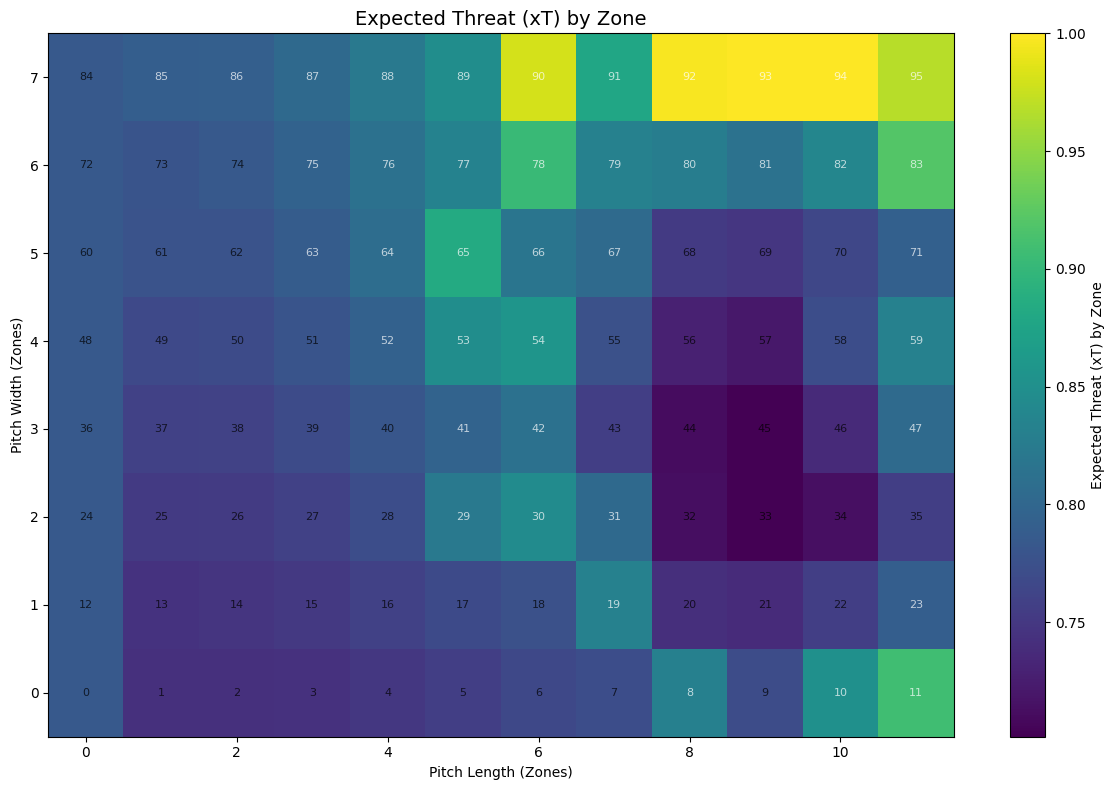

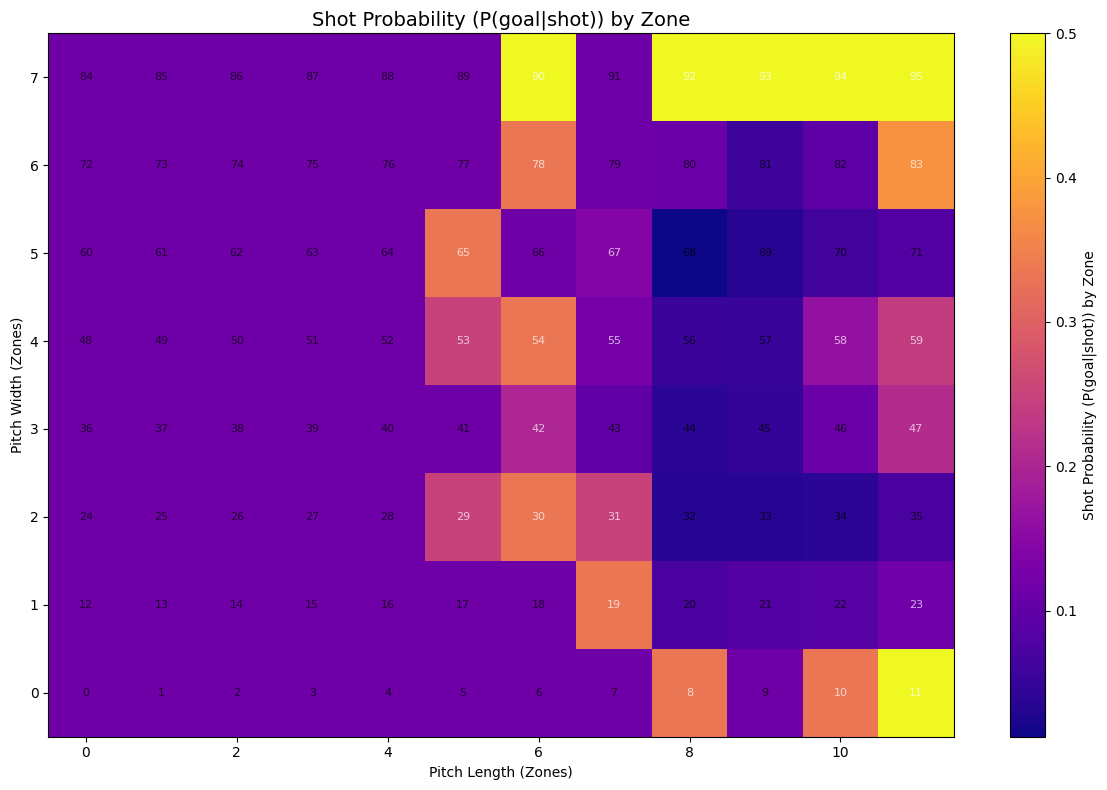

2025-08-27 06:30:29,761 - INFO - 
🔝 Top 10 Highest Value Zones:
2025-08-27 06:30:29,769 - INFO -     zone  xT_value
93    93  1.000000
94    94  0.999049
92    92  0.997136
90    90  0.980944
95    95  0.968112
83    83  0.920256
11    11  0.908474
78    78  0.903548
65    65  0.884208
91    91  0.878386
2025-08-27 06:30:29,770 - INFO - 
🔻 Bottom 10 Lowest Value Zones:
2025-08-27 06:30:29,776 - INFO -     zone  xT_value
33    33  0.701327
45    45  0.702046
44    44  0.711084
32    32  0.712426
34    34  0.713561
57    57  0.720824
56    56  0.729309
46    46  0.736352
21    21  0.738510
20    20  0.741003
2025-08-27 06:30:29,798 - WARNING - 🚨 Found 842 transitions exceeding 60.0m:       location_zone  end_zone  count  start_x  start_y  end_x  end_y  \
8               1.0         9      1     15.0      5.0   95.0    5.0   
16              1.0        19      3     15.0      5.0   75.0   15.0   
17              1.0        23      1     15.0      5.0  115.0   15.0   
25              1.0  

In [41]:
# ---------- STEP 11: Validation & Visualization ----------
def plot_heatmap(values_matrix, title, cmap='viridis'):
    plt.figure(figsize=(12, 8))
    im = plt.imshow(values_matrix, cmap=cmap, origin='lower', aspect='auto')
    plt.colorbar(im, label=title)
    plt.title(title, fontsize=14)
    plt.xlabel('Pitch Length (Zones)')
    plt.ylabel('Pitch Width (Zones)')
    
    # Add zone numbers
    for i in range(GRID_Y):
        for j in range(GRID_X):
            plt.text(j, i, f'{i*GRID_X + j}', ha="center", va="center", 
                    color="white" if values_matrix[i, j] > np.median(values_matrix) else "black",
                    fontsize=8, alpha=0.7)
    plt.tight_layout()
    plt.show()

xt_grid = V.reshape((GRID_Y, GRID_X))
plot_heatmap(xt_grid, 'Expected Threat (xT) by Zone')

shot_prob_grid = shot_probs.reshape((GRID_Y, GRID_X))
plot_heatmap(shot_prob_grid, 'Shot Probability (P(goal|shot)) by Zone', cmap='plasma')

logger.info("\n🔝 Top 10 Highest Value Zones:")
logger.info(zone_values.nlargest(10, 'xT_value').to_string())
logger.info("\n🔻 Bottom 10 Lowest Value Zones:")
logger.info(zone_values.nsmallest(10, 'xT_value').to_string())

# Transition distance analysis
transitions_with_dist = transition_counts.copy()
transitions_with_dist['start_x'] = (transitions_with_dist['location_zone'] % GRID_X * CELL_X) + (CELL_X / 2)
transitions_with_dist['start_y'] = (transitions_with_dist['location_zone'] // GRID_X * CELL_Y) + (CELL_Y / 2)
transitions_with_dist['end_x'] = (transitions_with_dist['end_zone'] % GRID_X * CELL_X) + (CELL_X / 2)
transitions_with_dist['end_y'] = (transitions_with_dist['end_zone'] // GRID_X * CELL_Y) + (CELL_Y / 2)
transitions_with_dist['distance'] = np.sqrt(
    (transitions_with_dist['end_x'] - transitions_with_dist['start_x'])**2 +
    (transitions_with_dist['end_y'] - transitions_with_dist['start_y'])**2
)

outliers = transitions_with_dist[transitions_with_dist['distance'] > HYPERPARAMS["max_dist_threshold"]]
if not outliers.empty:
    logger.warning(f"🚨 Found {len(outliers)} transitions exceeding {HYPERPARAMS['max_dist_threshold']}m: {outliers}")

logger.info(f"\n🚀 Longest 10 transitions (distance in meters):")
logger.info(transitions_with_dist.nlargest(10, 'distance')[['location_zone', 'end_zone', 'distance', 'count']].to_string())

logger.info(f"\n👑 Top 10 Players by Total xT Added:")
logger.info(player_xt.head(10).to_string())
logger.info(f"\n🏆 Top 10 Teams by Total xT Added:")
logger.info(team_xt.head(10).to_string())

logger.info(f"\n⭐ Top 5 Actions by xT Added (Game-Changing Plays):")
logger.info(actions.nlargest(5, 'xT_added')[['player', 'team', 'type', 'location_zone', 'end_zone', 'xT_added']].to_string())

logger.info(f"\n💥 Bottom 5 Actions by xT Added (Costly Mistakes/Risks):")
logger.info(actions.nsmallest(5, 'xT_added')[['player', 'team', 'type', 'location_zone', 'end_zone', 'xT_added']].to_string())

# Shot validation
shots_with_xt = events[events['type'] == 'Shot'].copy()
shots_with_xt["location_zone"] = shots_with_xt.apply(
    lambda row: assign_zone(row["location_x"], row["location_y"]), 
    axis=1
)
shots_with_xt = shots_with_xt.dropna(subset=["location_zone"])
shots_with_xt["xT_value_of_shot_zone"] = shots_with_xt["location_zone"].apply(get_xt)
shots_with_xt["is_goal"] = shots_with_xt["shot_outcome"].fillna("").str.lower().eq("goal").astype(int)

avg_xt_goal = shots_with_xt[shots_with_xt['is_goal'] == 1]['xT_value_of_shot_zone'].mean()
avg_xt_no_goal = shots_with_xt[shots_with_xt['is_goal'] == 0]['xT_value_of_shot_zone'].mean()

# Correlation analysis
correlation = np.corrcoef(shots_with_xt['xT_value_of_shot_zone'], 
                         shots_with_xt['is_goal'])[0, 1]

logger.info("\n⚽ CHECK 7: Shot xT vs. Actual Goals")
logger.info(f"Average xT Value of shots that were GOALS: {avg_xt_goal:.4f}")
logger.info(f"Average xT Value of shots that were NOT GOALS: {avg_xt_no_goal:.4f}")
logger.info(f"Correlation between xT and goals: {correlation:.3f}")

if avg_xt_goal > avg_xt_no_goal:
    logger.info("✅ VALIDATION PASSED: Goals come from higher value zones, as expected.")
else:
    logger.warning("❌ VALIDATION FAILED: Goals do not come from higher value zones. Review the model.")

In [42]:
# ---------- STEP 12: Finalization ----------
logger.info("\n" + "="*60)
logger.info("PHASE 2 FINALIZATION: Saving Outputs for Phase 3")
logger.info("="*60)

ZONE_XT_FILE = BASE / "zone_xt_values.csv"
zone_values.to_csv(ZONE_XT_FILE, index=False)
logger.info(f"💾 Zone xT values lookup table saved to: {ZONE_XT_FILE}")

important_columns = [
    'id', 'match_id', 'index', 'period', 'timestamp', 'minute', 'second',
    'type', 'possession', 'possession_team', 'play_pattern', 'team',
    'player', 'position', 'location_x', 'location_y', 'location_zone',
    'pass_end_location_x', 'pass_end_location_y', 'carry_end_location_x',
    'carry_end_location_y', 'end_zone', 'xT_start', 'xT_end', 'xT_added'
]

available_columns = [col for col in important_columns if col in actions.columns]
actions_optimized = actions[available_columns].copy()

XT_ACTIONS_FILE = BASE / "wsl_actions_with_xt_OPENPLAY.csv"
actions_optimized.to_csv(XT_ACTIONS_FILE, index=False)
logger.info(f"💾 Main xT-enriched actions dataset saved to: {XT_ACTIONS_FILE}")
logger.info(f" - Total open-play actions: {len(actions_optimized):,}")
logger.info(f" - File contains columns: {list(actions_optimized.columns)}")

SAMPLE_ACTIONS_FILE = BASE / "wsl_actions_with_xt_SAMPLE.csv"
sample_size = 10000
actions_sample = actions_optimized.head(sample_size).copy()
actions_sample.to_csv(SAMPLE_ACTIONS_FILE, index=False)
logger.info(f"💾 Sample dataset ({sample_size} rows) saved to: {SAMPLE_ACTIONS_FILE}")

# Save transition matrix
np.save(BASE / "transition_matrix.npy", T)
logger.info("💾 Transition matrix saved")

logger.info("\n📊 PHASE 2 SUMMARY STATISTICS:")
logger.info(f" - Final Number of Zones: {NUM_ZONES}")
logger.info(f" - Highest xT Zone: Zone {zone_values['zone'].iloc[zone_values['xT_value'].idxmax()]} (Value: {zone_values['xT_value'].max():.4f})")
logger.info(f" - Lowest xT Zone: Zone {zone_values['zone'].iloc[zone_values['xT_value'].idxmin()]} (Value: {zone_values['xT_value'].min():.4f})")
logger.info(f" - Total Open-Play Passes & Carries: {len(actions_optimized):,}")
logger.info(f" - Total xT Added by all actions: {actions_optimized['xT_added'].sum():.2f}")

top_5_players = actions_optimized.groupby('player')['xT_added'].sum().nlargest(5)
logger.info("\n⭐ Top 5 Players by Total xT Added (Preview for Phase 3):")
for player, xt in top_5_players.items():
    logger.info(f" - {player}: {xt:.2f}")

logger.info("\n🎉 PHASE 2 COMPLETED SUCCESSFULLY!")

2025-08-27 06:30:49,994 - INFO - 
2025-08-27 06:30:49,997 - INFO - PHASE 2 FINALIZATION: Saving Outputs for Phase 3
2025-08-27 06:30:49,998 - INFO - ============================================================
2025-08-27 06:30:50,095 - INFO - 💾 Zone xT values lookup table saved to: E:\MSc Big Data Analytics in Football\WSL project\Statsbombpy data\zone_xt_values.csv
2025-08-27 06:30:58,068 - INFO - 💾 Main xT-enriched actions dataset saved to: E:\MSc Big Data Analytics in Football\WSL project\Statsbombpy data\wsl_actions_with_xt_OPENPLAY.csv
2025-08-27 06:30:58,072 - INFO -  - Total open-play actions: 473,805
2025-08-27 06:30:58,074 - INFO -  - File contains columns: ['id', 'match_id', 'minute', 'second', 'type', 'possession', 'possession_team', 'team', 'player', 'location_x', 'location_y', 'location_zone', 'pass_end_location_x', 'pass_end_location_y', 'carry_end_location_x', 'carry_end_location_y', 'end_zone', 'xT_start', 'xT_end', 'xT_added']
2025-08-27 06:30:58,394 - INFO - 💾 Sample 